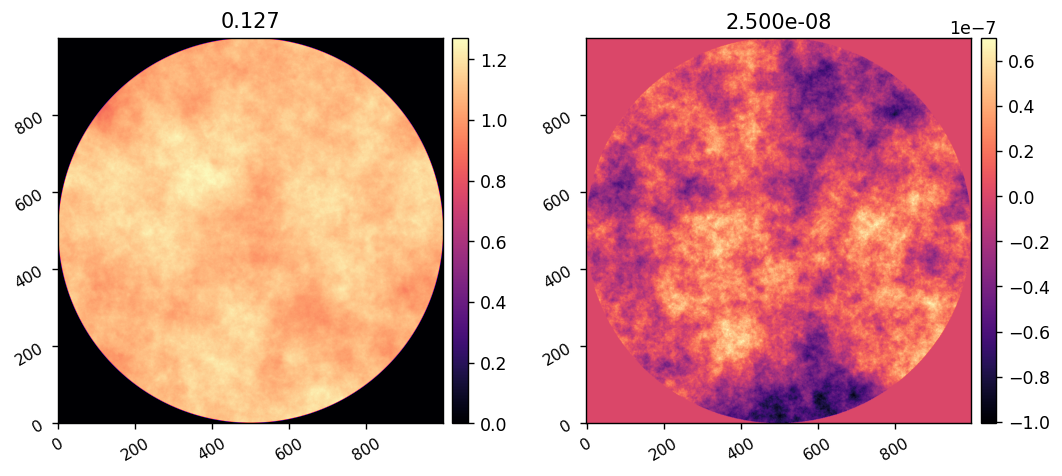

array(2.5e-08)

In [129]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from IPython.display import clear_output
import copy 

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


In [163]:
model.llowfsc_defocus

<Quantity 1.75 mm>

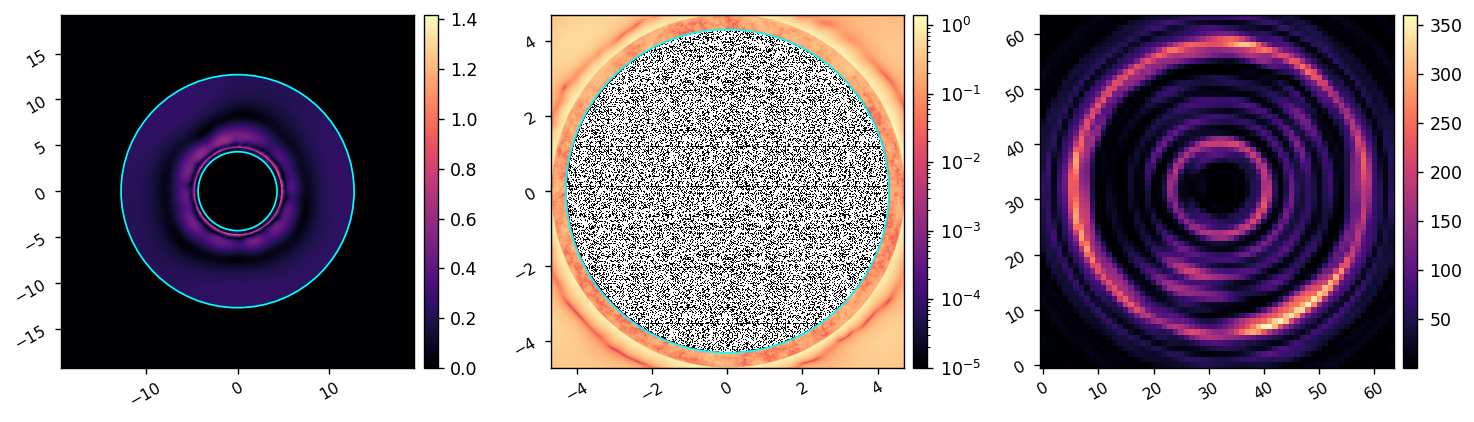

In [170]:
model = cscoob.CORO()
model.WFE = WFE
model.use_fpm = True
model.use_llowfsc()
model.llowfsc_fl = 200*u.mm
model.llowfsc_defocus = 2.1*u.mm

wfs = model.calc_wfs()
llowfsc_im = xp.abs(wfs[-1])**2

# imshow1(im)
imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), llowfsc_im, npix2=model.npix, lognorm2=True, vmin2=1e-5, 
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),],
                  )

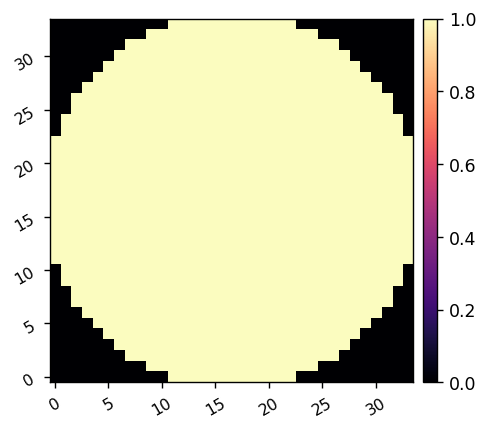

array(952)

In [171]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact+1)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

20


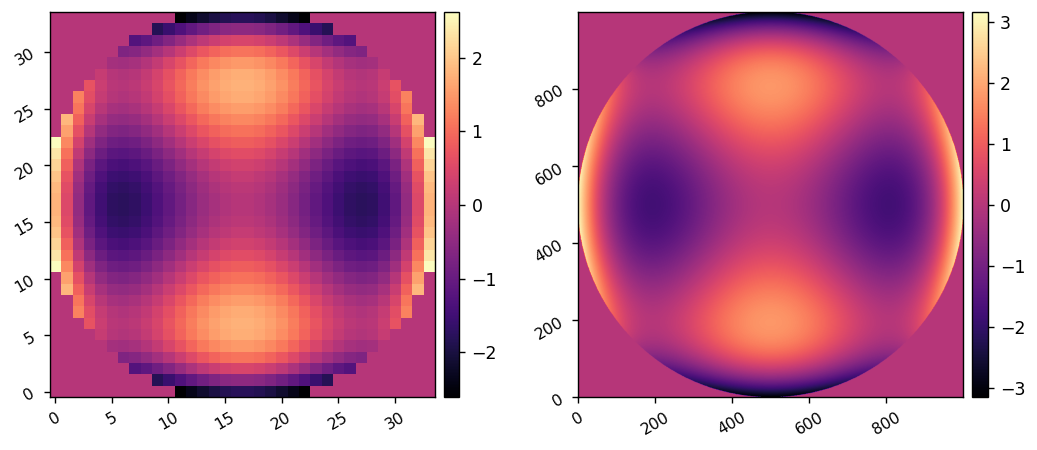

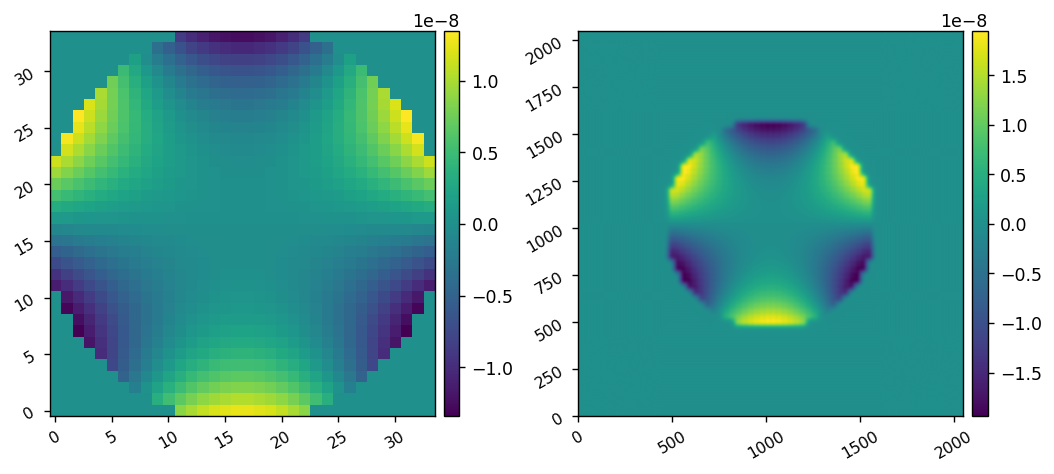

In [172]:
Nmodes = 20
dm_modes = lina.utils.create_zernike_modes(dm_mask, nmodes=Nmodes, remove_modes=1)
wfe_modes = lina.utils.create_zernike_modes(model.APERTURE, nmodes=Nmodes, remove_modes=1)

znames = ['tip', 'tilt', 'Defocus', 'O-Astig', 'V-Astig', 'V-Coma', 'H-Coma', 'V-Trefoil', 'O-Trefoil', 
          'Spherical', 'V-Astig 2', 'O-Astig 2', 'V-Quadrafoil', 'O-Quadrafoil',
          'H-Coma 2', 'V-Coma 2', 'O-Trefoil 2', 'V-Trefoil 2', 'O-Pentafoil 2', 'V-Pentafoil',]
print(len(znames))

i = 10
imshow2(dm_modes[i], wfe_modes[i])

model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


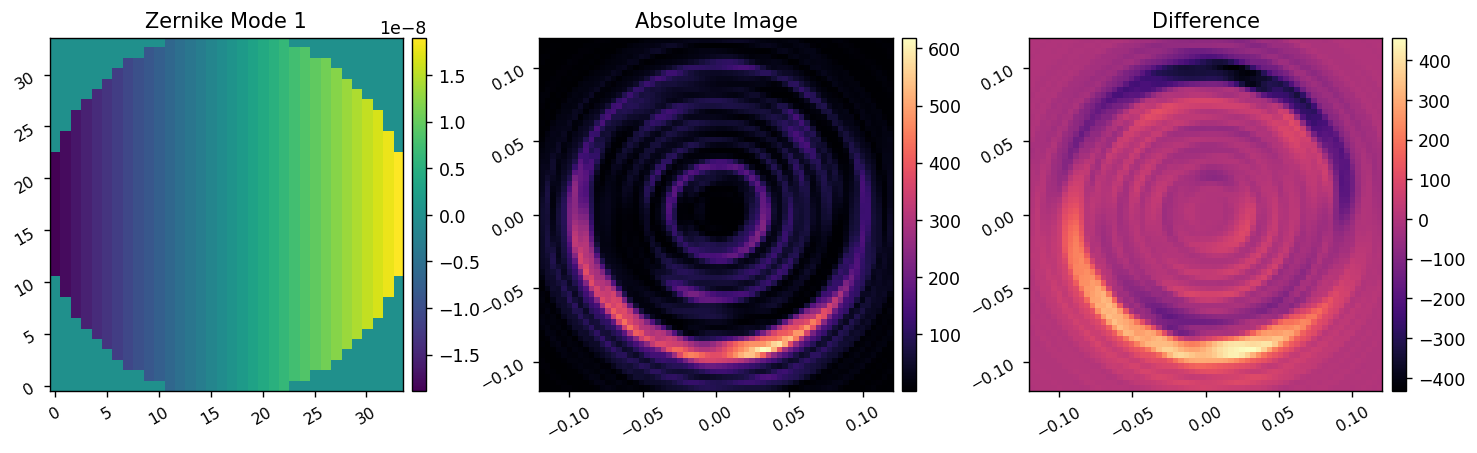

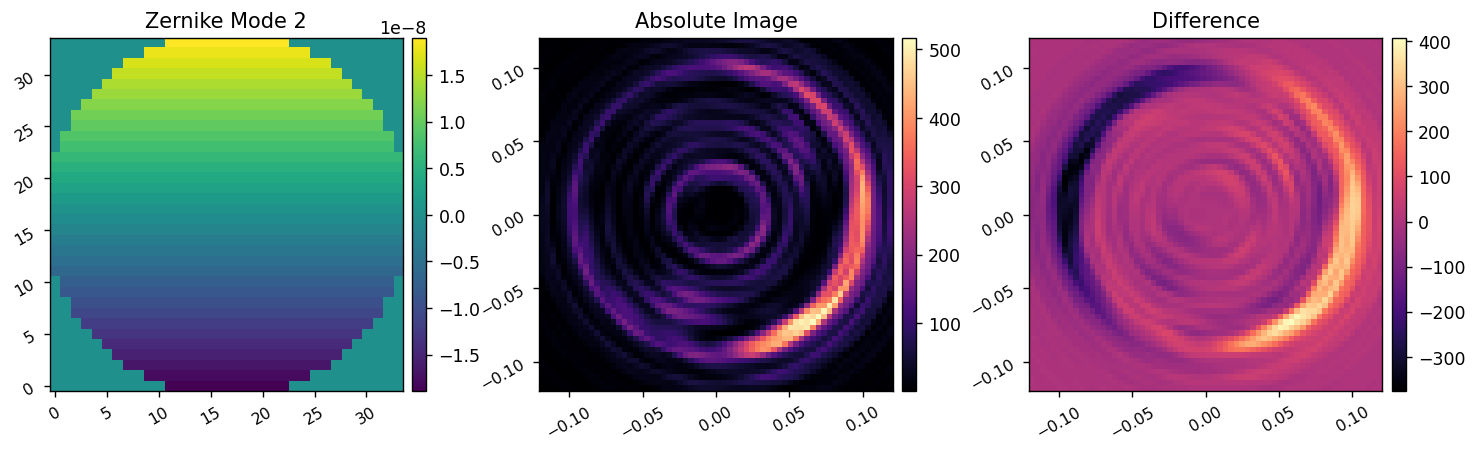

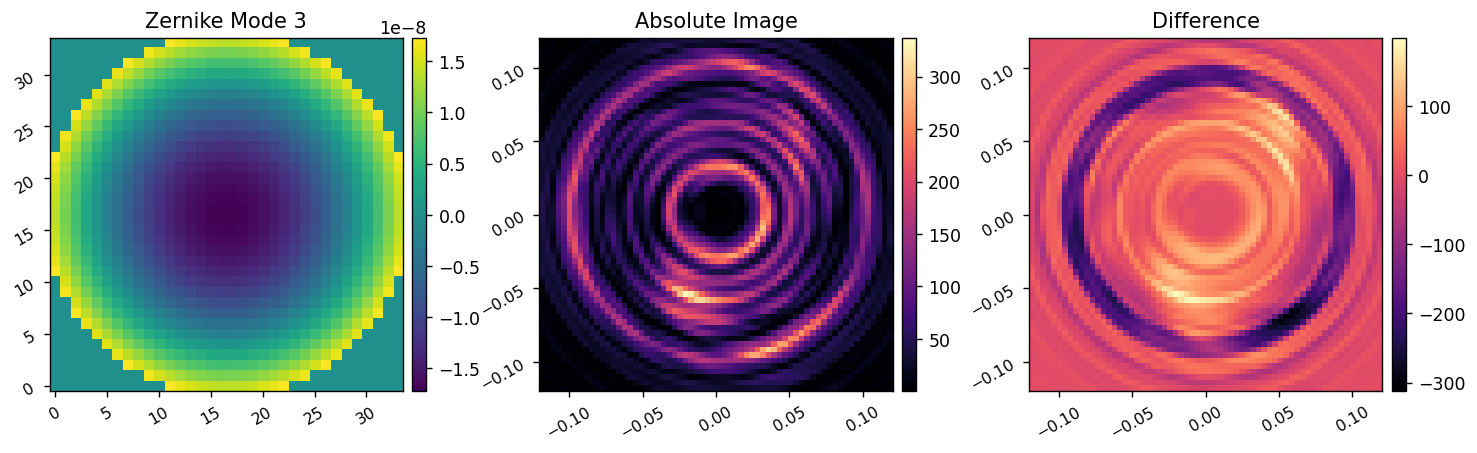

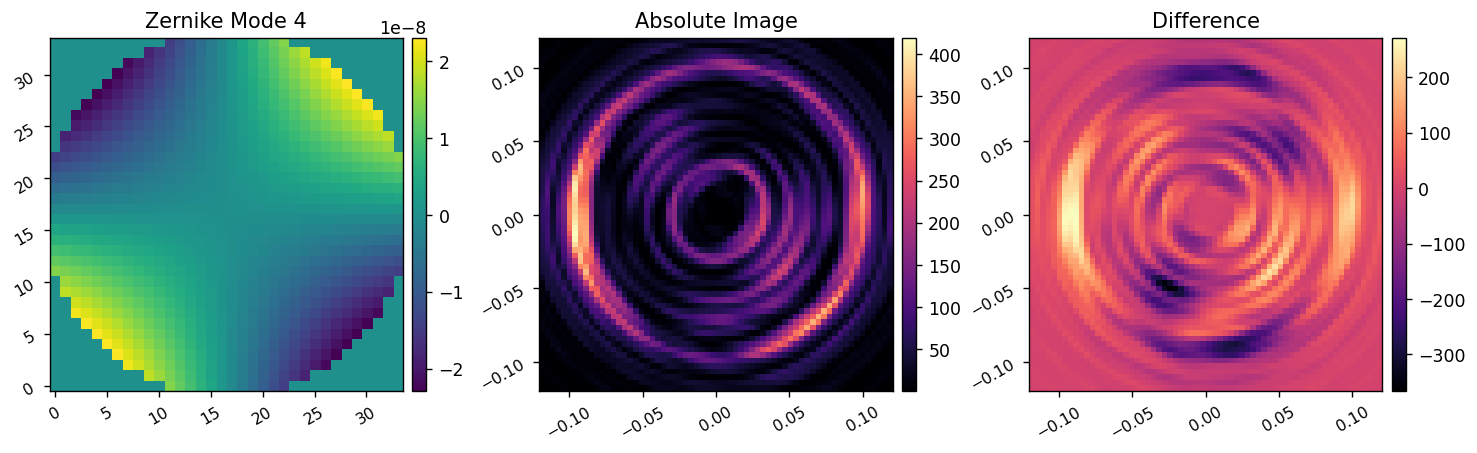

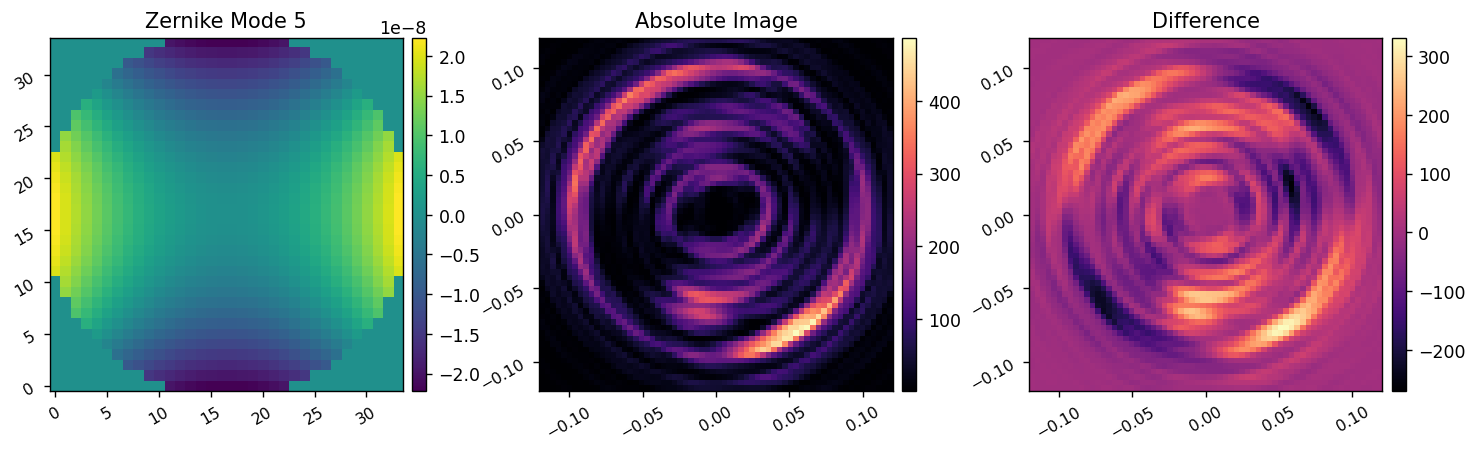

In [173]:
amp = 10e-9

model.use_llowfsc()

model.reset_dm()
model.WFE = WFE

im_ref = model.snap()

responses = xp.zeros((Nmodes, model.nllowfsc**2))
for i in range(Nmodes):
    mode = dm_zernikes[i]

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    if i < 5:
        imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
                pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
                cmap1='viridis')

response_matrix = responses.T

In [174]:
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

In [175]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(7.70702613)

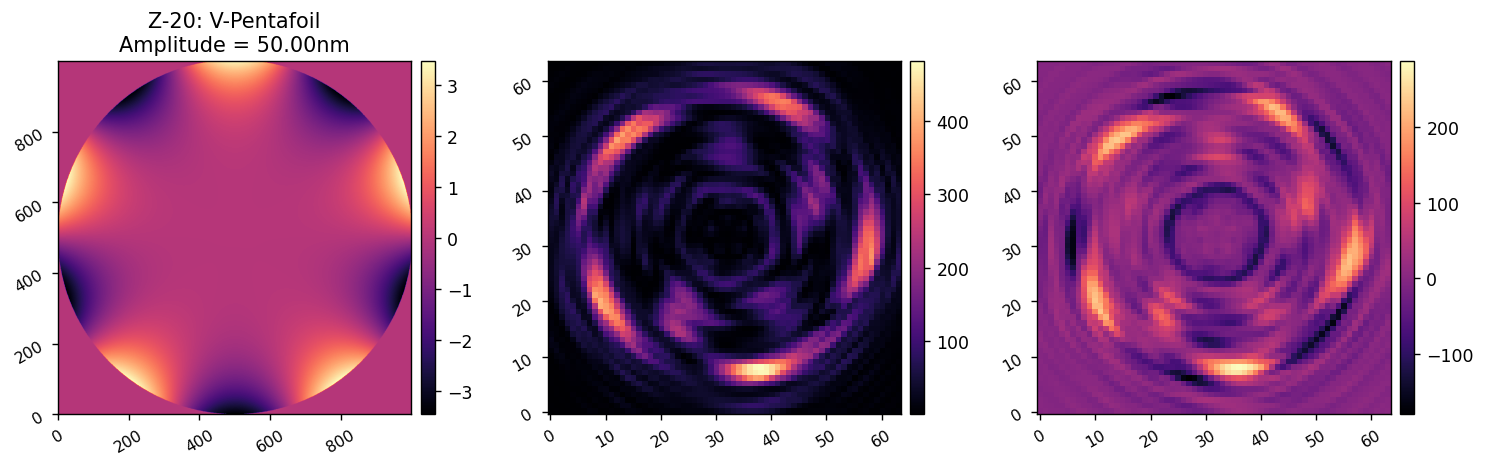

In [176]:
i = 1
Namps = 21
wfe_amps = np.linspace(-50e-9, 50e-9, Namps)

coeff = xp.zeros((Nmodes, Namps, Nmodes))
for i in range(Nmodes):
    for j in range(Namps):
        amp = wfe_amps[j]
        new_wfe = WFE * xp.exp(1j*2*np.pi * amp * wfe_modes[i]/(model.wavelength_c.to_value(u.m)))
        model.WFE = new_wfe
        llowfsc_im = model.snap()
        del_im = llowfsc_im - im_ref
        modal_coeff = control_matrix.dot(del_im.flatten())
        coeff[i,j,:] = copy.copy(modal_coeff)
        if j%5==0:
            imshow3(wfe_modes[i], llowfsc_im, del_im, f'Z-{i+1:d}: '+ znames[i] + f'\nAmplitude = {amp*1e9:.2f}nm')
            clear_output(wait=True)
    # if i>2:
    #     break

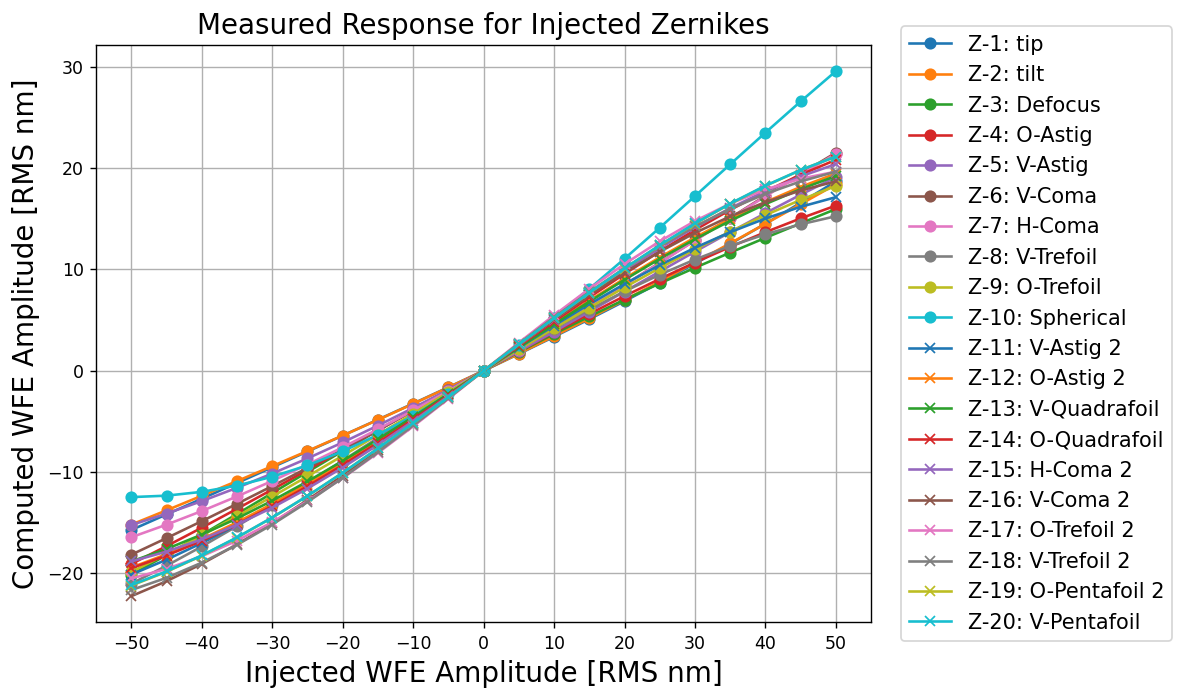

In [190]:
fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=125)

for i in range(Nmodes):
    label = f'Z-{i+1:d}: '+znames[i]
    style = '-o' if i<10 else '-x'
    ax.plot(wfe_amps*1e9, 1e9*ensure_np_array(coeff[i,:,i]), style, label=label)
ax.set_title('Measured Response for Injected Zernikes', fontsize=16)
ax.set_xlabel('Injected WFE Amplitude [RMS nm]', fontsize=16)
ax.set_ylabel('Computed WFE Amplitude [RMS nm]', fontsize=16)
ax.legend(bbox_to_anchor=[1.025, 1.05], fontsize=12)
ax.set_xticks(wfe_amps[::2]*1e9)
ax.grid()


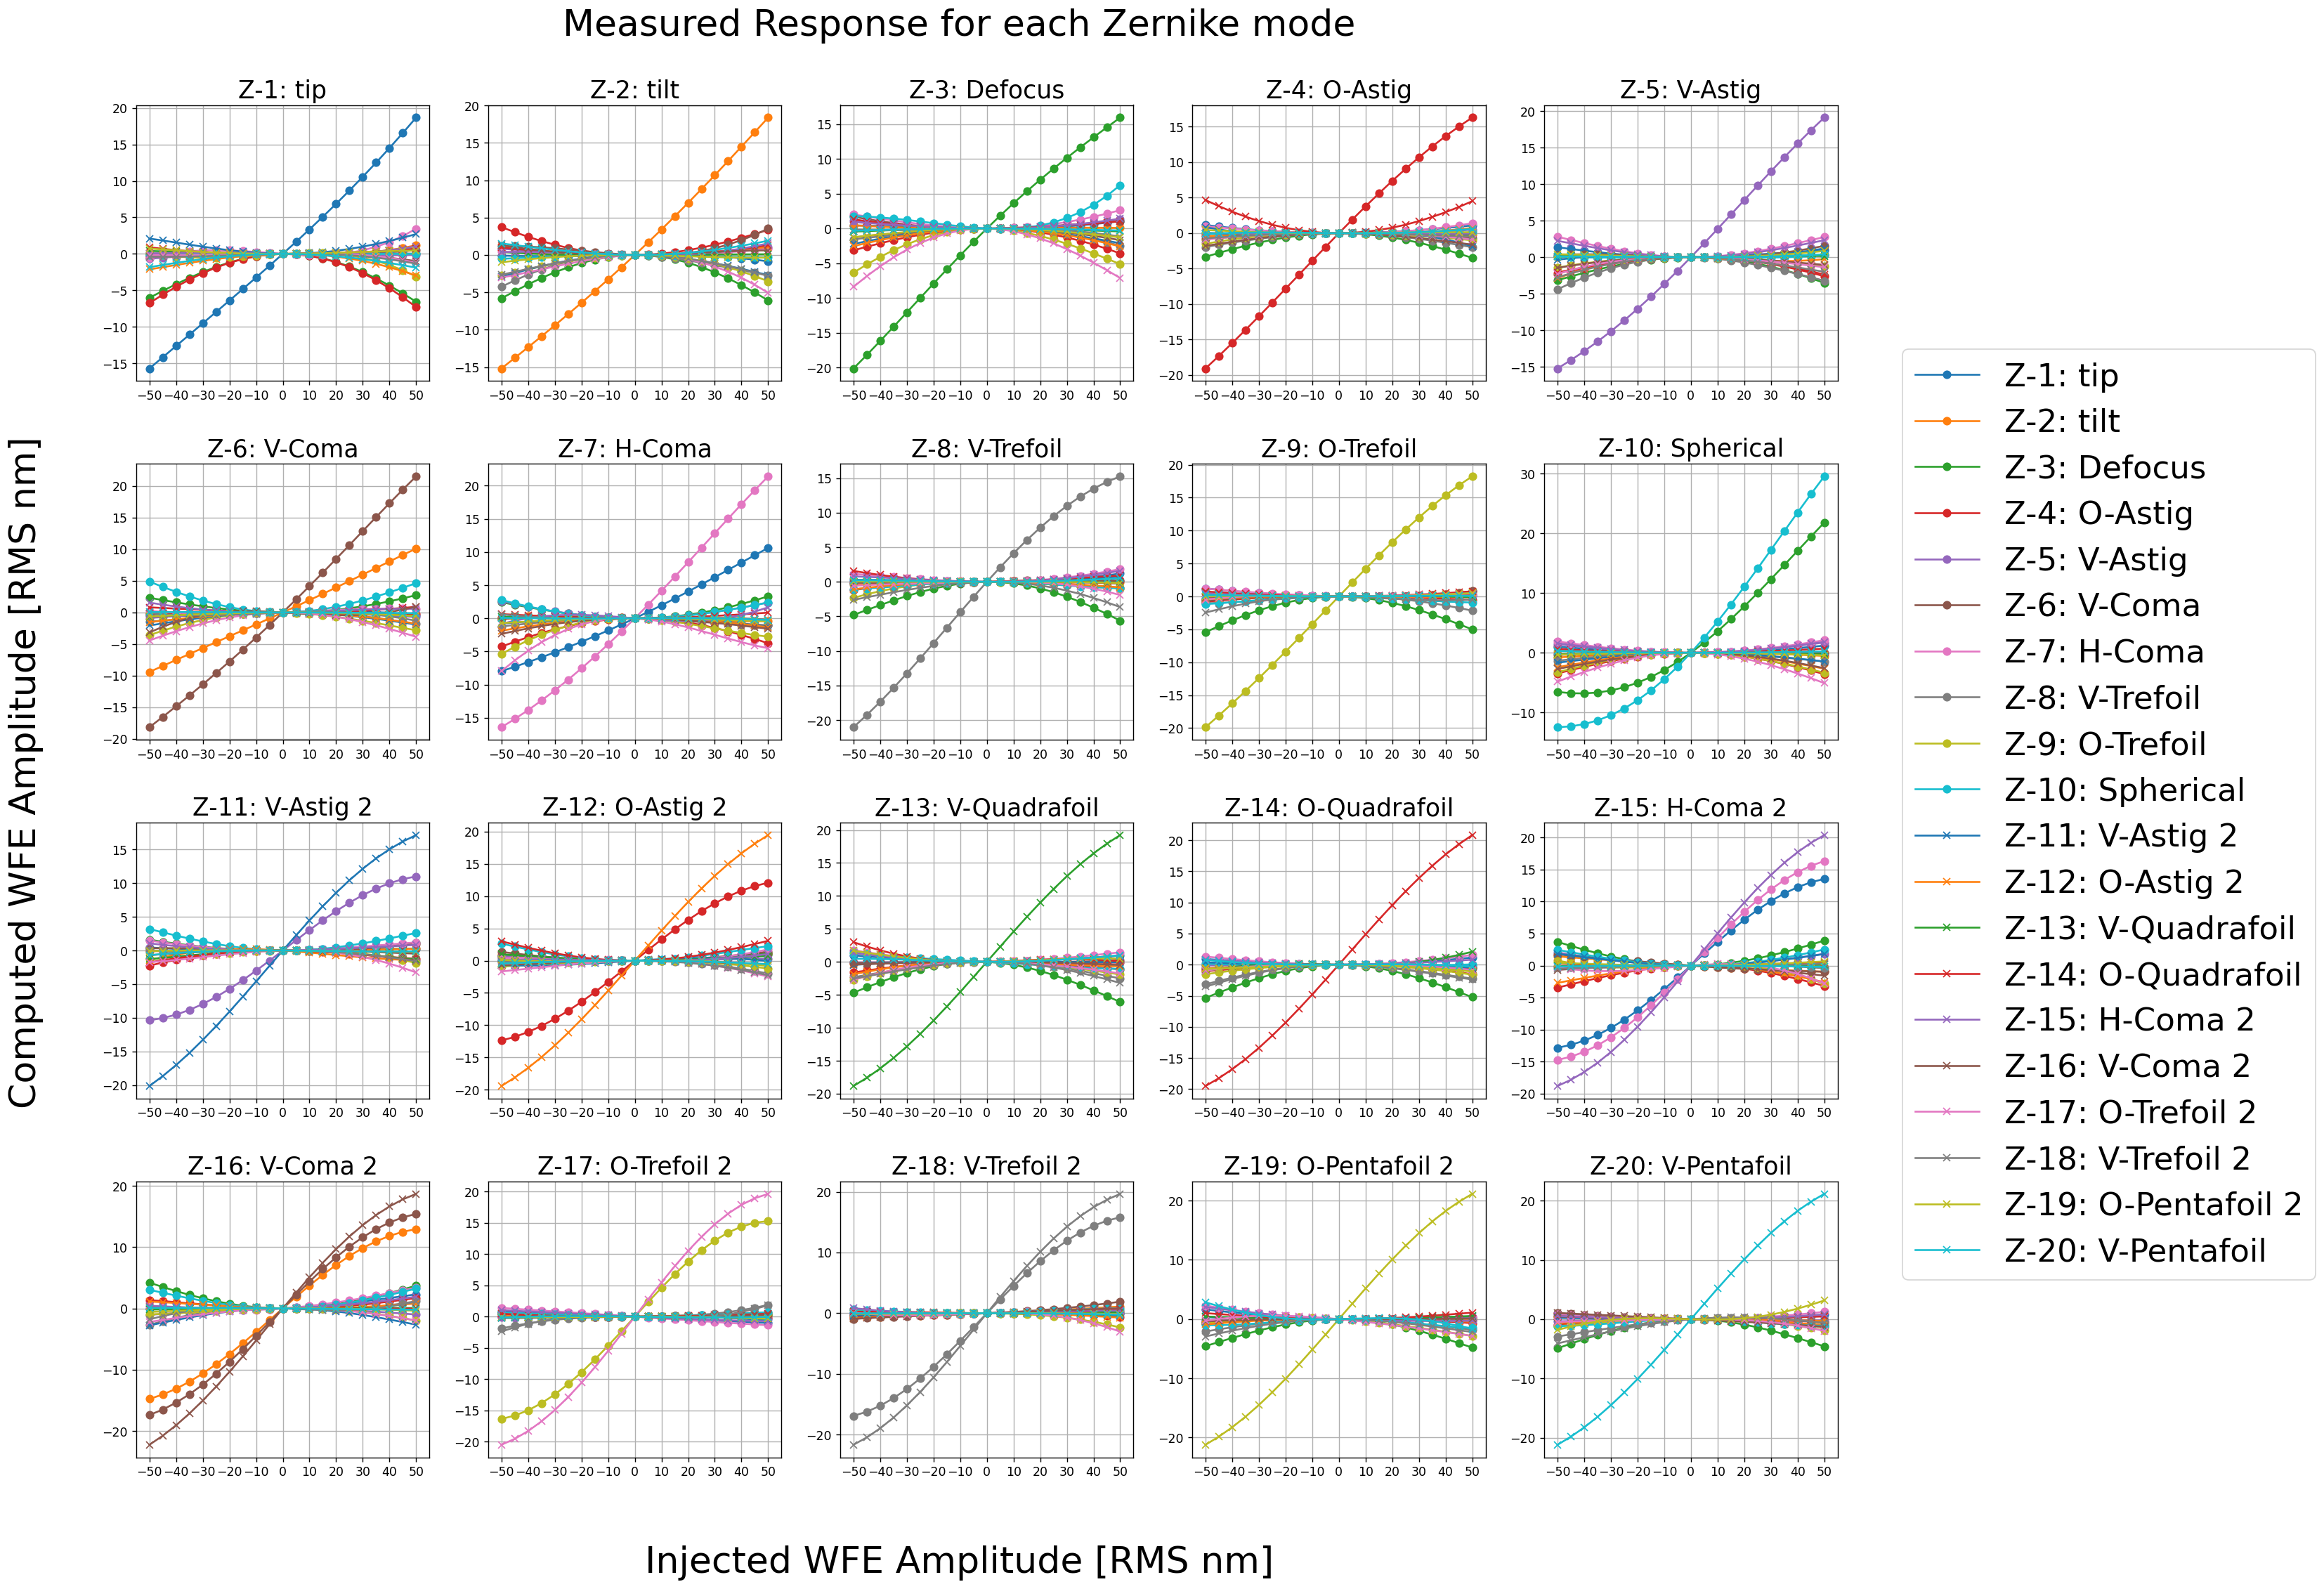

In [178]:

fig, ax = plt.subplots(4,5, figsize=(25,20), dpi=125)

for i in range(Nmodes):
    ax_ind = [int(np.floor(i/5)), i%5]
    for j in range(Nmodes):
        label = f'Z-{j+1:d}: '+znames[j]
        style = '-o' if j<10 else '-x'
        ax[ax_ind[0], ax_ind[1]].plot(wfe_amps*1e9, 1e9*ensure_np_array(coeff[i,:,j]), style, label=label)
    ax[ax_ind[0], ax_ind[1]].set_title(f'Z-{i+1:d}: '+znames[i], fontsize=20)
    ax[ax_ind[0], ax_ind[1]].set_xticks(wfe_amps[::2]*1e9)
    ax[ax_ind[0], ax_ind[1]].grid()
# ax.legend(bbox_to_anchor=[1.2, 1.1])
fig.text(0.5, 0.05, 'Injected WFE Amplitude [RMS nm]', fontsize=30, ha='center', va='center')
fig.text(0.075, 0.5, 'Computed WFE Amplitude [RMS nm]', ha='center', va='center', fontsize=30, rotation='vertical')
fig.text(0.5, 0.925, 'Measured Response for each Zernike mode', fontsize=30, ha='center', va='center')
handles, labels = ax[-1,-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=[1.125, 0.75], fontsize=26)
plt.subplots_adjust(hspace=0.3)

In [139]:
znames = ['Tip', 'Tilt', 'Defocus', 'O-Astig', 'V-Astig', 'V-Coma', 'H-Coma', 'V-Trefoil', 'O-Trefoil', 
          'Spherical', 'V-Astig 2', 'O-Astig 2', 'V-Quadrafoil', 'O-Quadrafoil',
          'H-Coma 2', 'V-Coma 2', 'O-Trefoil 2', 'V-Trefoil 2', 'O-Pentafoil 2', 'V-Pentafoil',]
len(znames)

20

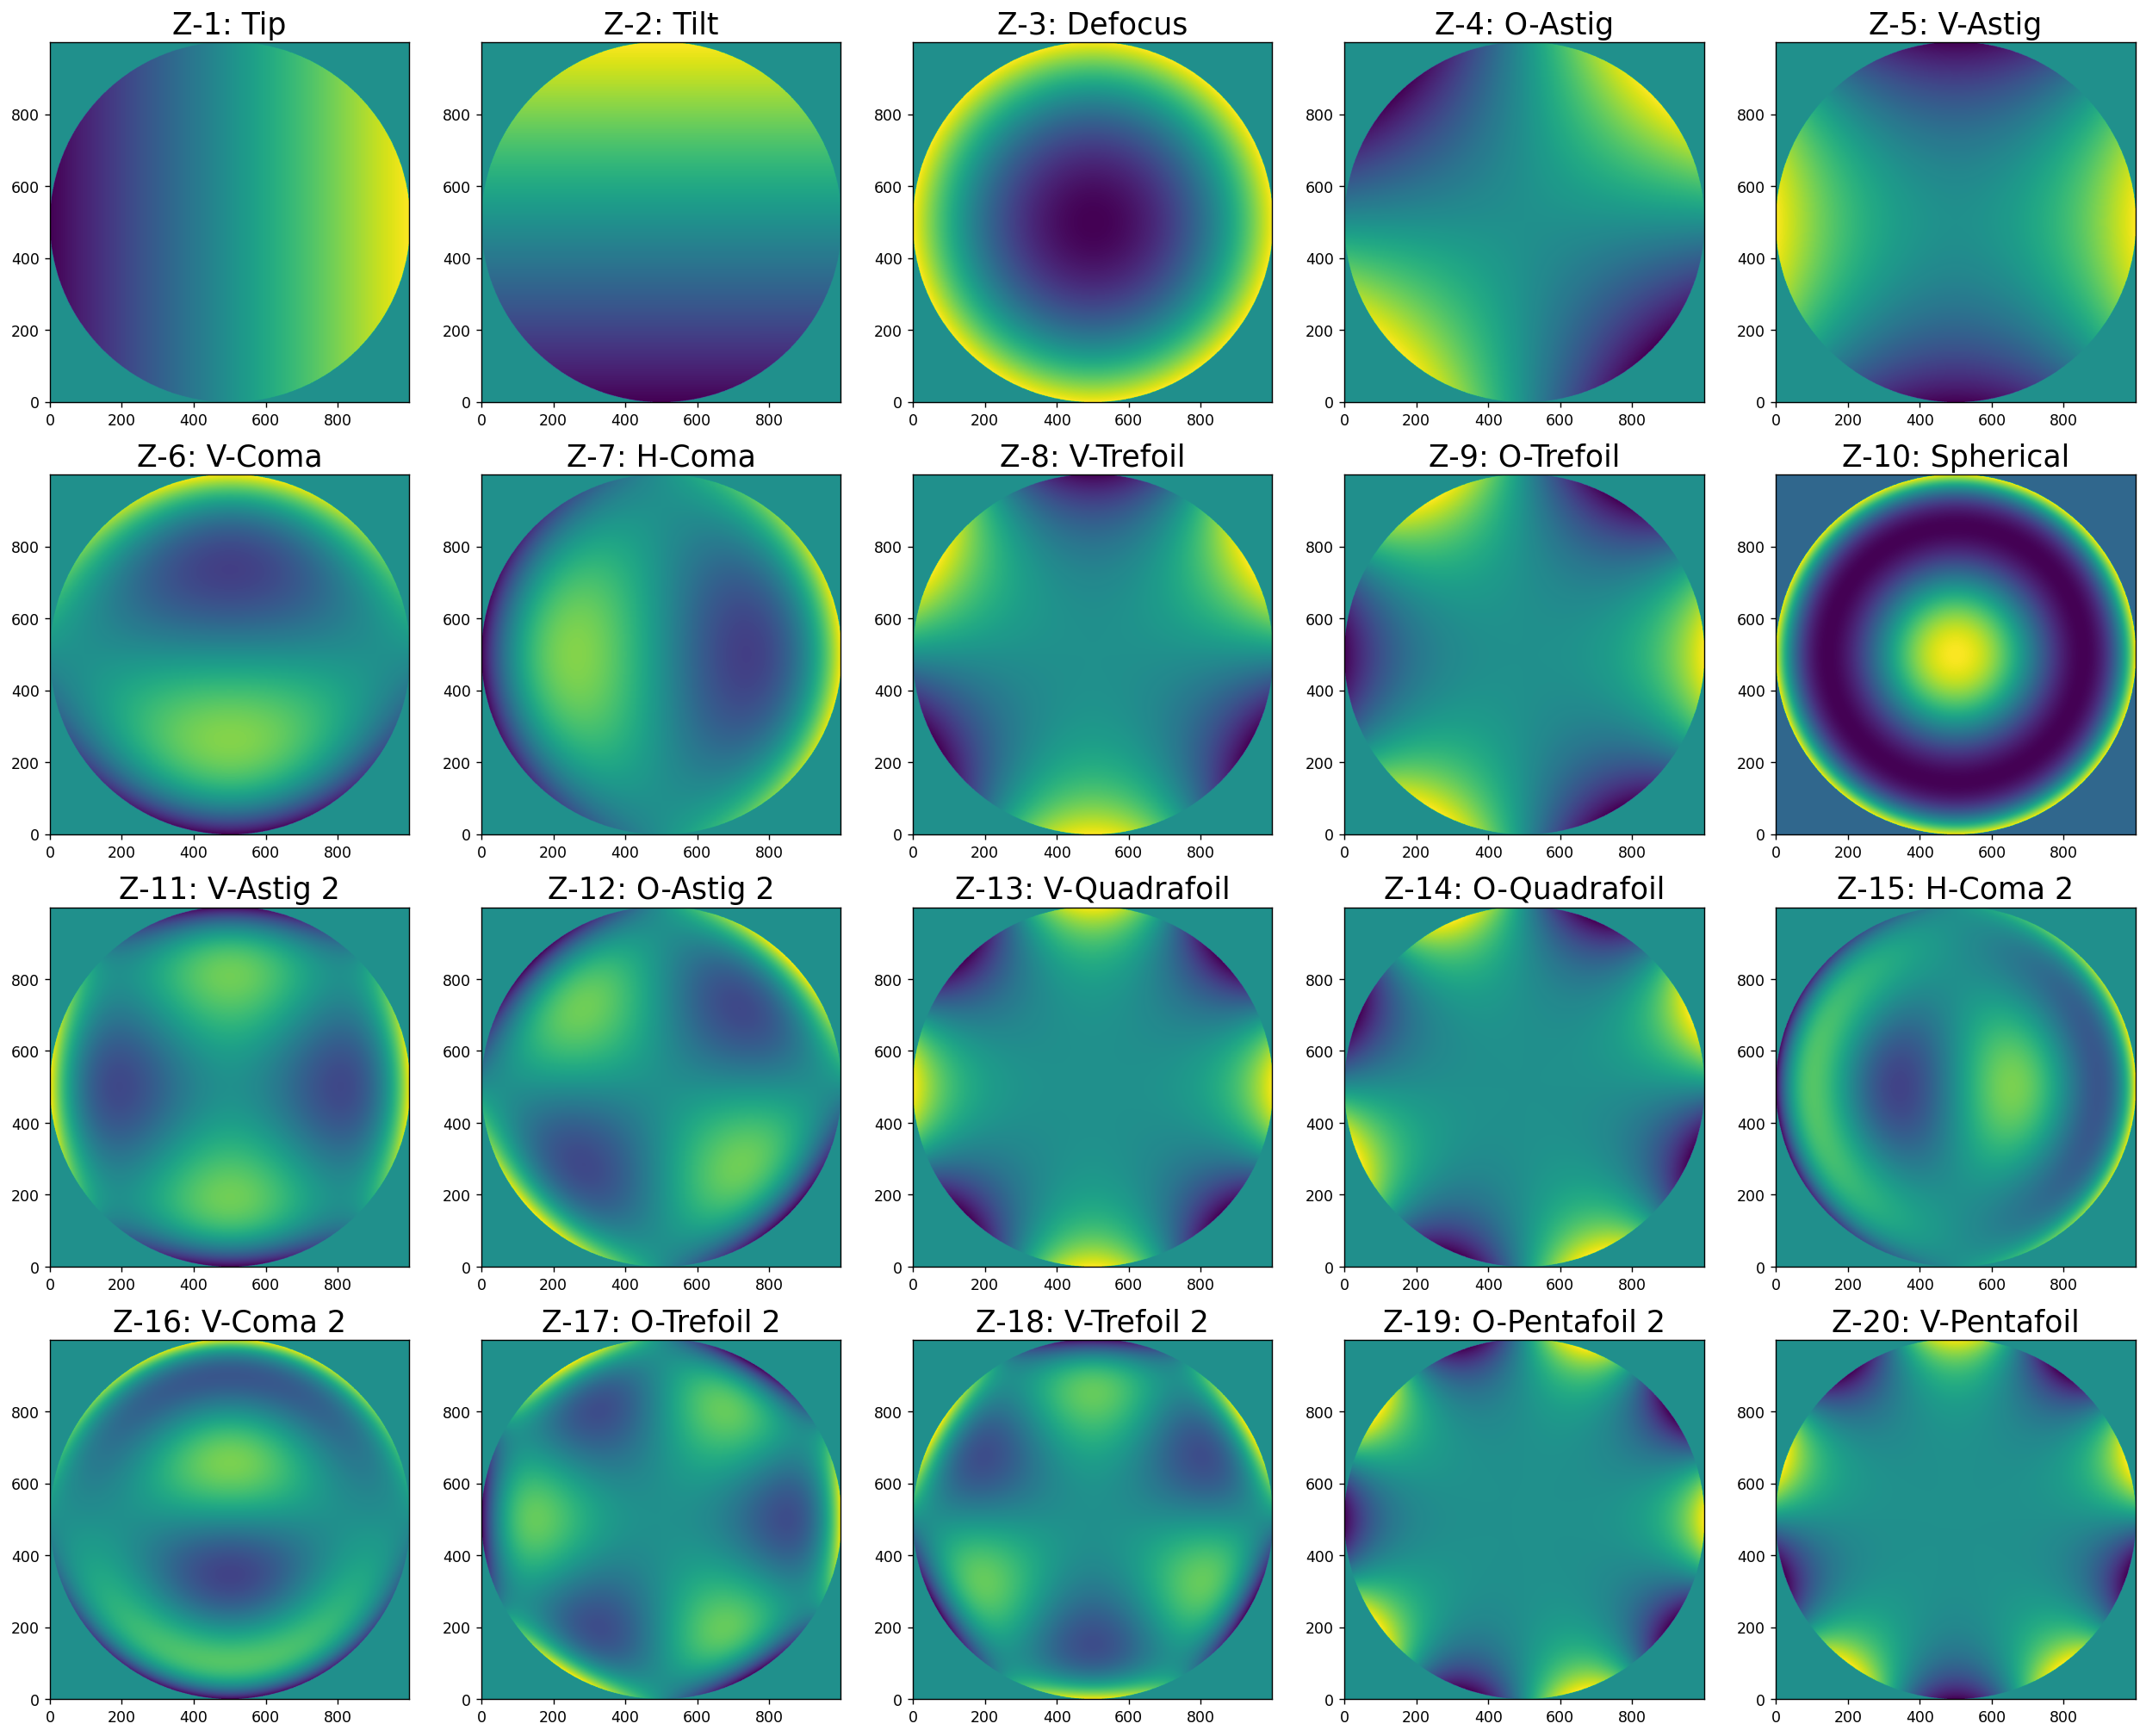

In [158]:
fig, ax = plt.subplots(4,5, figsize=(25,20), dpi=125)
j = 1

for i in range(Nmodes):
    ax_ind = [int(np.floor(i/5)), i%5]
    ax[ax_ind[0], ax_ind[1]].imshow(ensure_np_array(wfe_modes[i]))
    ax[ax_ind[0], ax_ind[1]].set_title(f'Z-{i+1:d}: '+znames[i], fontsize=20)